Copyright (c) 2021 [윤기태]

https://github.com/yoonkt200/learning-spoons-nano-degree

[MIT License](https://github.com/yoonkt200/learning-spoons-nano-degree/blob/master/LICENSE.txt)

# LearningSpoons - NanoDegree

-----

# 4회차 - (유저 데이터 분석, 군집 분석)

- [1. 주문데이터 전처리](#1.-주문데이터-전처리)
    - [데이터 병합 및 탐색]
    - [데이터 전처리]
- [2. 유저향 주문데이터 분석](#2.-유저향-주문데이터-분석)
    - [유저 프로파일링]
    - [재주문 분석]
- [3. 유저향 시각화](#3.-유저향-시각화)
    - [거주 분포 시각화]
- [4. 프로파일 기반 군집분석](#4.-프로파일-기반-군집분석)
    - [유저 프로파일의 벡터 표현]
    - [다양한 관점으로 K-means 군집 분석 수행]
    - [t-sne 차원 축소 시각화]
- [5. 심화 예제](#5.-심화-예제)
    - [유저 행동 기반 장바구니 분석]

----

- 강의 순서
    - 각종 EDA 케이스를 통해, Data Preprocessing과 데이터를 탐색하는 법을 공부합니다.
    - 유저향 분석을 통해 프로파일링을 수행합니다.
    - 프로파일링 기반 군집 분석 활용방법을 알아봅니다.
    - 유저향 분석을 통해 수행할 수 있는 고급 분석 기법을 알아봅니다.
    
- 숙제
    - K-means, Word2Vec 알고리즘 공부해보기

In [172]:
pip install sklearn bokeh apriori apyori

Note: you may need to restart the kernel to use updated packages.


In [173]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [174]:
data_dir = "../dataset/"

# 1. 주문데이터 전처리

### [데이터 병합 및 탐색]

----
#### *주문데이터 기준으로 데이터 병합*

In [175]:
order_df = pd.read_csv(data_dir + "olist_order_items_dataset.csv")
shipping_df = pd.read_csv(data_dir + "olist_orders_dataset.csv")
category_df = pd.read_csv(data_dir + "olist_products_dataset.csv")
user_df = pd.read_csv(data_dir + "olist_customers_dataset.csv")
location_df = pd.read_csv(data_dir + "olist_geolocation_dataset.csv")
product_category_name_translation_df = pd.read_csv(data_dir + "product_category_name_translation.csv")
payments_dataset = pd.read_csv(data_dir + "olist_order_payments_dataset.csv")

In [176]:
order_df['order_id'] = order_df['order_id'].astype(str)
shipping_df['order_id'] = shipping_df['order_id'].astype(str)
order_df = order_df.merge(shipping_df, how='left', on='order_id')

In [177]:
order_df['product_id'] = order_df['product_id'].astype(str)
category_df['product_id'] = category_df['product_id'].astype(str)
order_df = order_df.merge(category_df, how='left', on='product_id')

In [178]:
order_df['customer_id'] = order_df['customer_id'].astype(str)
user_df['customer_id'] = user_df['customer_id'].astype(str)
order_df = order_df.merge(user_df, how='left', on='customer_id')

In [179]:
order_df['customer_zip_code_prefix'] = order_df['customer_zip_code_prefix'].astype(str)
location_df['geolocation_zip_code_prefix'] = location_df['geolocation_zip_code_prefix'].astype(str)
location_df.columns = ['customer_zip_code_prefix', 'lat', 'lng', 'city', 'state']
location_df = location_df.groupby('customer_zip_code_prefix').agg({'lat': 'mean', 'lng': 'mean', 'city': 'first', 'state': 'first'}).reset_index()
order_df = order_df.merge(location_df, how='left', on='customer_zip_code_prefix')

In [180]:
order_df['product_category_name'] = order_df['product_category_name'].astype(str)
product_category_name_translation_df['product_category_name'] = product_category_name_translation_df['product_category_name'].astype(str)
order_df = order_df.merge(product_category_name_translation_df, how='left', on='product_category_name')

In [181]:
payments_dataset['order_id'] = payments_dataset['order_id'].astype(str)
order_df = order_df.merge(payments_dataset, how='left', on='order_id')

In [182]:
order_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,customer_state,lat,lng,city,state,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,RJ,-21.762775,-41.309633,campos dos goytacazes,RJ,cool_stuff,1.0,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,SP,-20.220527,-50.903424,santa fe do sul,SP,pet_shop,1.0,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,MG,-19.870305,-44.593326,pará de minas,MG,furniture_decor,1.0,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,SP,-23.089925,-46.611654,atibaia,SP,perfumery,1.0,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,SP,-23.243402,-46.827614,varzea paulista,SP,garden_tools,1.0,credit_card,3.0,218.04


In [183]:
order_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state', 'lat',
       'lng', 'city', 'state', 'product_category_name_english',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [184]:
anal_columns = ['order_id', 'product_id', 'customer_id', 'customer_unique_id',
                'order_item_id', 'price', 'freight_value', 
                'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date',
                'product_category_name_english',
                'customer_zip_code_prefix', 'lat', 'lng', 'city', 'state',
                'payment_type', 'payment_installments', 'payment_value'
                ]

In [185]:
order_df = order_df[anal_columns]

In [186]:
order_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,order_estimated_delivery_date,product_category_name_english,customer_zip_code_prefix,lat,lng,city,state,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,2017-09-29 00:00:00,cool_stuff,28013,-21.762775,-41.309633,campos dos goytacazes,RJ,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,2017-05-15 00:00:00,pet_shop,15775,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,2018-02-05 00:00:00,furniture_decor,35661,-19.870305,-44.593326,pará de minas,MG,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,...,2018-08-20 00:00:00,perfumery,12952,-23.089925,-46.611654,atibaia,SP,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,...,2017-03-17 00:00:00,garden_tools,13226,-23.243402,-46.827614,varzea paulista,SP,credit_card,3.0,218.04


In [187]:
order_df.isnull().sum()

order_id                            0
product_id                          0
customer_id                         0
customer_unique_id                  0
order_item_id                       0
price                               0
freight_value                       0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_customer_date    2567
order_estimated_delivery_date       0
product_category_name_english    1723
customer_zip_code_prefix            0
lat                               312
lng                               312
city                              312
state                             312
payment_type                        3
payment_installments                3
payment_value                       3
dtype: int64

----
#### *결제 관련 피쳐 탐색*

In [188]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117604 entries, 0 to 117603
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117604 non-null  object 
 1   product_id                     117604 non-null  object 
 2   customer_id                    117604 non-null  object 
 3   customer_unique_id             117604 non-null  object 
 4   order_item_id                  117604 non-null  int64  
 5   price                          117604 non-null  float64
 6   freight_value                  117604 non-null  float64
 7   order_status                   117604 non-null  object 
 8   order_purchase_timestamp       117604 non-null  object 
 9   order_approved_at              117589 non-null  object 
 10  order_delivered_customer_date  115037 non-null  object 
 11  order_estimated_delivery_date  117604 non-null  object 
 12  product_category_name_english 

<AxesSubplot:>

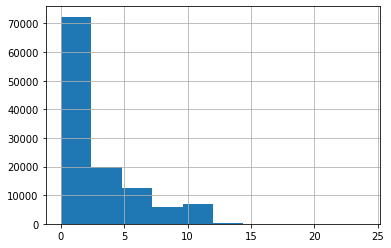

In [189]:
plt.ticklabel_format(style='plain')
order_df['payment_installments'].hist(bins=10)

<AxesSubplot:>

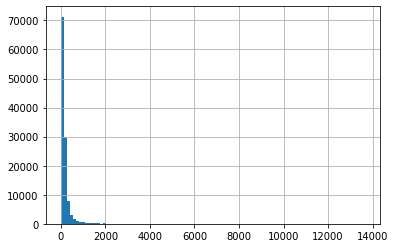

In [190]:
plt.ticklabel_format(style='plain')
order_df['payment_value'].hist(bins=100)

In [191]:
order_df['payment_type'].value_counts()

credit_card    86769
boleto         22867
voucher         6274
debit_card      1691
Name: payment_type, dtype: int64

- credit_card : 신용카드
- boleto : 현금 결제 (지정된 장소로 가서 납부하는 브라질 고유의 현금결제 수단이라고 함)
- voucher : 충전식 선불결제
- debit_card : 직불카드

----
#### *데이터 전처리*

In [192]:
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])
order_df['order_approved_at'] = pd.to_datetime(order_df['order_approved_at'])
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df['order_delivered_customer_date'])
order_df['order_estimated_delivery_date'] = pd.to_datetime(order_df['order_estimated_delivery_date'])

In [193]:
order_df = order_df[order_df['order_status']=='delivered']
order_df = order_df.dropna()

----
# 2. 유저향 주문데이터 분석
### [유저 프로파일링]

----
#### *유저별 주문 횟수*

In [194]:
order_df['customer_unique_id'].nunique()

91809

In [195]:
order_df.groupby('customer_unique_id')['order_id'].nunique()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    1
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 91809, dtype: int64

<AxesSubplot:>

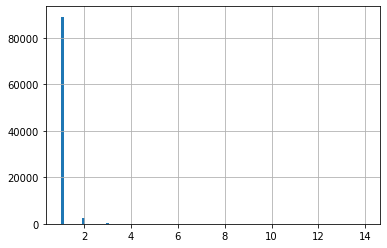

In [196]:
order_df.groupby('customer_unique_id')['order_id'].nunique().hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe0821bec10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe0795ef370>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe08219f670>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe0795efa90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe0795efe20>],
 'means': []}

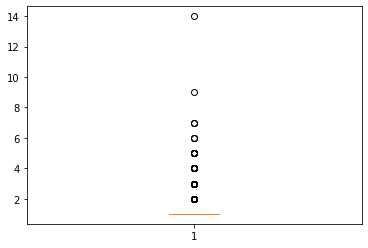

In [197]:
plt.boxplot(order_df.groupby('customer_unique_id')['order_id'].nunique())

In [198]:
사람마다 몇 번(unique orderid) 주문했는지를 데이터 프레임으로 표현해보세요

SyntaxError: invalid syntax (1325400765.py, line 1)

In [200]:
order_df.groupby('customer_unique_id')['order_id'].nunique().describe()

count    91809.000000
mean         1.033080
std          0.206859
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: order_id, dtype: float64

In [201]:
user_df = order_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
user_df.head()

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [202]:
user_df[user_df['order_id']>1].shape

(2732, 2)

In [203]:
user_df[user_df['order_id']>2].shape

(220, 2)

----
#### *유저별 주문 갯수*

In [204]:
order_df.groupby('customer_unique_id')['order_id'].count()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 91809, dtype: int64

<AxesSubplot:>

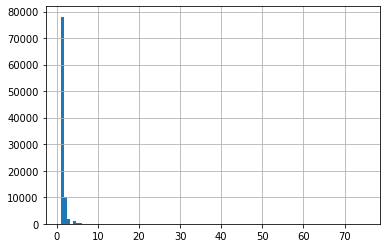

In [205]:
order_df.groupby('customer_unique_id')['order_id'].count().hist(bins=100)

In [206]:
user_df = order_df.groupby('customer_unique_id')['order_id'].count().reset_index()
user_df.head()

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [207]:
user_df[user_df['order_id']>1].shape

(13768, 2)

In [208]:
user_df[user_df['order_id']>2].shape

(3534, 2)

----
#### *유저별 주문 카테고리 갯수*

In [209]:
order_df.columns

Index(['order_id', 'product_id', 'customer_id', 'customer_unique_id',
       'order_item_id', 'price', 'freight_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'product_category_name_english', 'customer_zip_code_prefix', 'lat',
       'lng', 'city', 'state', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [210]:
user_df = order_df.groupby('customer_unique_id')['product_category_name_english'].nunique().reset_index()

In [211]:
user_df.head()

,customer_unique_id,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [212]:
user_df['product_category_name_english'].describe()

count    91809.000000
mean         1.024998
std          0.167300
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: product_category_name_english, dtype: float64

In [213]:
user_df[user_df['product_category_name_english']>1].shape

(2154, 2)

----
#### *유저별 주문 주기*

In [138]:
유저별 "주문 날짜를 리스트로 하는 column"을 포함한 데이터프레임

SyntaxError: invalid syntax (3318517574.py, line 1)

In [214]:
order_df['order_purchase_date'] = order_df['order_purchase_timestamp'].dt.date

In [215]:
user_df = order_df.groupby('customer_unique_id')['order_purchase_date'].nunique().reset_index()
user_df.shape

(91809, 2)

In [216]:
user_df = user_df[user_df['order_purchase_date']>1]
user_df.head()

,customer_unique_id,order_purchase_date
103,004288347e5e88a27ded2bb23747066c,2
399,011575986092c30523ecb71ff10cb473,2
414,011b4adcd54683b480c4d841250a987f,2
423,012452d40dafae4df401bced74cdb490,2
432,012a218df8995d3ec3bb221828360c86,2


In [217]:
user_df.shape

(1966, 2)

In [218]:
cuid_list = user_df['customer_unique_id'].tolist()
temp_df = order_df[order_df['customer_unique_id'].isin(cuid_list)]

In [219]:
temp_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,product_category_name_english,customer_zip_code_prefix,lat,lng,city,state,payment_type,payment_installments,payment_value,order_purchase_date
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,pet_shop,15775,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83,2017-04-26
40,0017afd5076e074a48f1f1a4c7bac9c5,fe59a1e006df3ac42bf0ceb876d70969,8085a9af46f619bc25966f151a362b0d,98758d88bf4b8eef1372ddee45d63178,1,809.10,44.29,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,...,computers_accessories,57250,-9.784323,-36.349941,campo alegre,AL,credit_card,10.0,853.39,2017-04-06
56,0020a222f55eb79a372d0efee3cca688,e19ddcc85537b41f22116c8d5425ef46,0c45155afd8ff99622c40824057f9b34,87ae4c644c15d9c6b6f826dfec33b340,1,29.99,15.10,delivered,2017-08-15 02:45:18,2017-08-15 03:03:44,...,furniture_decor,27273,-22.518974,-44.136149,volta redonda,RJ,credit_card,4.0,45.09,2017-08-15
153,005d9a5423d47281ac463a968b3936fb,fb7a100ec8c7b34f60cec22b1a9a10e0,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,1,49.99,18.12,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,toys,13720,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18
154,005d9a5423d47281ac463a968b3936fb,4c3ae5db49258df0784827bdacf3b396,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,2,24.99,13.58,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,baby,13720,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18


In [220]:
def get_dayterm_by_orderdate(x):
    prev_purchase_date = None
    dayterm_list = []
    for purchase_date in x.sort_values('order_purchase_date')['order_purchase_date'].tolist():
        if prev_purchase_date is not None:
            dayterm_list.append((purchase_date - prev_purchase_date).days)
        prev_purchase_date = purchase_date
    return dayterm_list

temp_df.groupby('customer_unique_id').apply(lambda x: get_dayterm_by_orderdate(x))

customer_unique_id
004288347e5e88a27ded2bb23747066c               [171]
011575986092c30523ecb71ff10cb473                [60]
011b4adcd54683b480c4d841250a987f            [177, 0]
012452d40dafae4df401bced74cdb490            [330, 0]
012a218df8995d3ec3bb221828360c86             [0, 42]
                                          ...       
fe81bb32c243a86b2f86fbf053fe6140    [9, 115, 111, 7]
fed519569d16e690df6f89cb99d4e682                [88]
ff03923ad1eb9e32304deb7f9b2a45c9                [33]
ff8892f7c26aa0446da53d01b18df463               [186]
ff922bdd6bafcdf99cb90d7f39cea5b3           [182, 22]
Length: 1966, dtype: object

In [221]:
temp_df = temp_df.groupby('customer_unique_id').apply(lambda x: get_dayterm_by_orderdate(x)).reset_index()
temp_df.head()

,customer_unique_id,0
0,004288347e5e88a27ded2bb23747066c,[171]
1,011575986092c30523ecb71ff10cb473,[60]
2,011b4adcd54683b480c4d841250a987f,"[177, 0]"
3,012452d40dafae4df401bced74cdb490,"[330, 0]"
4,012a218df8995d3ec3bb221828360c86,"[0, 42]"


In [222]:
temp_df.columns = ['customer_unique_id', 'dayterm_list']

In [223]:
temp_df.head()

,customer_unique_id,dayterm_list
0,004288347e5e88a27ded2bb23747066c,[171]
1,011575986092c30523ecb71ff10cb473,[60]
2,011b4adcd54683b480c4d841250a987f,"[177, 0]"
3,012452d40dafae4df401bced74cdb490,"[330, 0]"
4,012a218df8995d3ec3bb221828360c86,"[0, 42]"


In [147]:
# 사람마다의 평균 주문 주기

In [148]:
temp_df['dayterm_mean'] = temp_df[0].apply(lambda x: np.mean(x))

In [149]:
temp_df.head()

,customer_unique_id,0,dayterm_mean
0,004288347e5e88a27ded2bb23747066c,[171],171.0
1,011575986092c30523ecb71ff10cb473,[60],60.0
2,011b4adcd54683b480c4d841250a987f,"[177, 0]",88.5
3,012452d40dafae4df401bced74cdb490,"[330, 0]",165.0
4,012a218df8995d3ec3bb221828360c86,"[0, 42]",21.0


<AxesSubplot:>

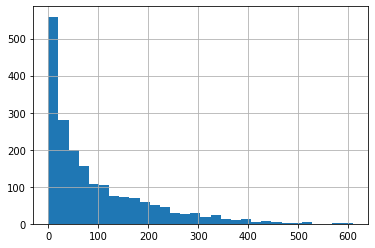

In [150]:
temp_df['dayterm_mean'].hist(bins=30)

----
#### *유저별 선호 가격대 (카테고리 기반)*

In [224]:
order_df.shape

(113069, 22)

In [225]:
# 거래 가격(price)의 z-score를 계산합니다. 이는 해당 데이터의 가격이 카테고리의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
order_df['z_score_in_category'] = order_df.groupby('product_category_name_english')['price'].transform(lambda x: (x - x.mean()) / x.std())

In [226]:
order_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,customer_zip_code_prefix,lat,lng,city,state,payment_type,payment_installments,payment_value,order_purchase_date,z_score_in_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,28013,-21.762775,-41.309633,campos dos goytacazes,RJ,credit_card,2.0,72.19,2017-09-13,-0.567002
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,15775,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83,2017-04-26,0.915267
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,35661,-19.870305,-44.593326,pará de minas,MG,credit_card,5.0,216.87,2018-01-14,1.257364
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,...,12952,-23.089925,-46.611654,atibaia,SP,credit_card,2.0,25.78,2018-08-08,-1.017445
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,...,13226,-23.243402,-46.827614,varzea paulista,SP,credit_card,3.0,218.04,2017-02-04,0.452103


In [227]:
def q02(x):
    return x.quantile(0.2)

def q80(x):
    return x.quantile(0.8)

category_price_df = order_df.groupby('product_category_name_english').agg({'z_score_in_category': [q02, q80]})
category_price_df.head()

z_score_in_category          
                                              q02       q80
product_category_name_english                              
agro_industry_and_commerce              -0.752557  0.244556
air_conditioning                        -0.661315  0.224604
art                                     -0.151633 -0.012965
arts_and_craftmanship                   -0.770073  0.728484
audio                                   -0.747253  0.327674

In [228]:
category_price_dict = category_price_df.to_dict()

In [229]:
category_price_dict

{('z_score_in_category',
  'q02'): {'agro_industry_and_commerce': -0.7525568025386538, 'air_conditioning': -0.6613154981840297, 'art': -0.1516327762341563, 'arts_and_craftmanship': -0.7700734130650558, 'audio': -0.747252648800402, 'auto': -0.5143975739449504, 'baby': -0.4275621501298089, 'bed_bath_table': -0.6488736662186889, 'books_general_interest': -0.5417698880544167, 'books_imported': -0.5625050068920596, 'books_technical': -0.696499303745205, 'cds_dvds_musicals': -0.7182430061427791, 'christmas_supplies': -0.8522568212195514, 'cine_photo': -0.6085667964561602, 'computers': -0.7412689492150076, 'computers_accessories': -0.47925595416968253, 'consoles_games': -0.48621208329327087, 'construction_tools_construction': -0.454159281039107, 'construction_tools_lights': -0.6825141527255499, 'construction_tools_safety': -0.5150671630048432, 'cool_stuff': -0.5689961003531501, 'costruction_tools_garden': -0.5250430124975763, 'costruction_tools_tools': -0.46989125590409836, 'diapers_and_hygie

In [230]:
order_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,customer_zip_code_prefix,lat,lng,city,state,payment_type,payment_installments,payment_value,order_purchase_date,z_score_in_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,28013,-21.762775,-41.309633,campos dos goytacazes,RJ,credit_card,2.0,72.19,2017-09-13,-0.567002
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,15775,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83,2017-04-26,0.915267
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,35661,-19.870305,-44.593326,pará de minas,MG,credit_card,5.0,216.87,2018-01-14,1.257364
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,...,12952,-23.089925,-46.611654,atibaia,SP,credit_card,2.0,25.78,2018-08-08,-1.017445
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,...,13226,-23.243402,-46.827614,varzea paulista,SP,credit_card,3.0,218.04,2017-02-04,0.452103


In [231]:
category_price_dict[('z_score_in_category', 'q02')]['audio']

-0.747252648800402

In [232]:
def get_price_level(z_score, category):
    lower_bound = category_price_dict[('z_score_in_category', 'q02')][category]
    upper_bound = category_price_dict[('z_score_in_category', 'q80')][category]
    if z_score < lower_bound:
        return 0
    else:
        if z_score > upper_bound:
            return 2
        else:
            return 1

In [233]:
# order_df.apply(lambda x: get_price_level(x['z_score_in_category'], x['product_category_name_english']), axis=1)

In [234]:
order_df['price_level'] = order_df.apply(lambda x: get_price_level(x['z_score_in_category'], x['product_category_name_english']), axis=1)

In [235]:
order_df['price_level'].head()

0    1
1    2
2    2
3    0
4    2
Name: price_level, dtype: int64

In [236]:
order_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,lat,lng,city,state,payment_type,payment_installments,payment_value,order_purchase_date,z_score_in_category,price_level
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,-21.762775,-41.309633,campos dos goytacazes,RJ,credit_card,2.0,72.19,2017-09-13,-0.567002,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83,2017-04-26,0.915267,2
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,-19.870305,-44.593326,pará de minas,MG,credit_card,5.0,216.87,2018-01-14,1.257364,2
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,...,-23.089925,-46.611654,atibaia,SP,credit_card,2.0,25.78,2018-08-08,-1.017445,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,...,-23.243402,-46.827614,varzea paulista,SP,credit_card,3.0,218.04,2017-02-04,0.452103,2


In [237]:
order_df.groupby('customer_unique_id')['price_level'].mean()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    2.0
0000b849f77a49e4a4ce2b2a4ca5be3f    0.0
0000f46a3911fa3c0805444483337064    1.0
0000f6ccb0745a6a4b88665a16c9f078    1.0
0004aac84e0df4da2b147fca70cf8255    2.0
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    2.0
fffea47cd6d3cc0a88bd621562a9d061    1.0
ffff371b4d645b6ecea244b27531430a    1.0
ffff5962728ec6157033ef9805bacc48    1.0
ffffd2657e2aad2907e67c3e9daecbeb    1.0
Name: price_level, Length: 91809, dtype: float64

<AxesSubplot:>

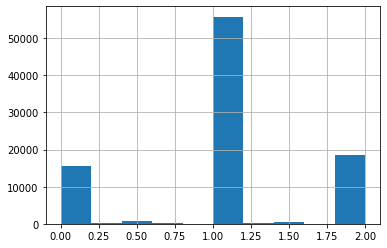

In [238]:
order_df.groupby('customer_unique_id')['price_level'].mean().hist()

----
#### *유저별 결제 정보*
- 결제 총액
- 선호 결제방법
- 평균 할부개월

In [239]:
order_df.columns

Index(['order_id', 'product_id', 'customer_id', 'customer_unique_id',
       'order_item_id', 'price', 'freight_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'product_category_name_english', 'customer_zip_code_prefix', 'lat',
       'lng', 'city', 'state', 'payment_type', 'payment_installments',
       'payment_value', 'order_purchase_date', 'z_score_in_category',
       'price_level'],
      dtype='object')

In [241]:
order_df.groupby('customer_unique_id')['payment_value'].sum()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2     141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      27.19
0000f46a3911fa3c0805444483337064      86.22
0000f6ccb0745a6a4b88665a16c9f078      43.62
0004aac84e0df4da2b147fca70cf8255     196.89
                                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    4134.84
fffea47cd6d3cc0a88bd621562a9d061      84.58
ffff371b4d645b6ecea244b27531430a     112.46
ffff5962728ec6157033ef9805bacc48     133.69
ffffd2657e2aad2907e67c3e9daecbeb      71.56
Name: payment_value, Length: 91809, dtype: float64

<AxesSubplot:>

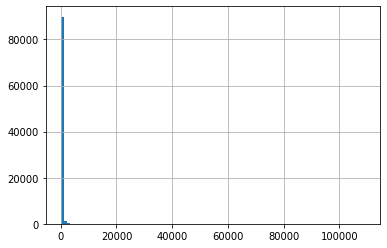

In [244]:
order_df.groupby('customer_unique_id')['payment_value'].sum().hist(bins=100)

In [245]:
order_df.groupby('customer_unique_id')['payment_value'].sum().describe()

count     91809.000000
mean        212.134840
std         644.361571
min           9.590000
25%          63.830000
50%         112.830000
75%         202.140000
max      109312.640000
Name: payment_value, dtype: float64

<AxesSubplot:>

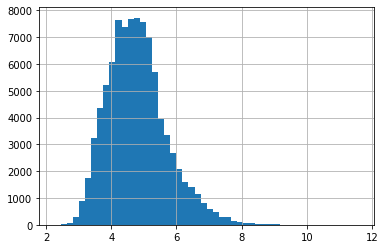

In [246]:
np.log(order_df.groupby('customer_unique_id')['payment_value'].sum()).hist(bins=50)

In [247]:
order_df.groupby('customer_unique_id')['payment_installments'].mean().describe()

count    91809.000000
mean         2.905209
std          2.682239
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         24.000000
Name: payment_installments, dtype: float64

<AxesSubplot:>

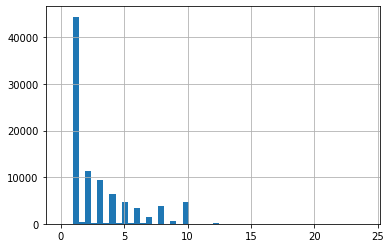

In [248]:
order_df.groupby('customer_unique_id')['payment_installments'].mean().hist(bins=50)

<AxesSubplot:>

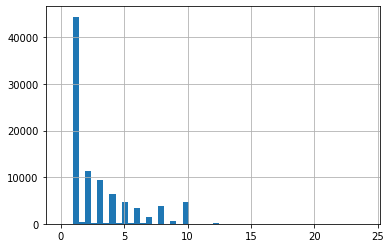

In [251]:
order_df.groupby('customer_unique_id')['payment_installments'].mean().hist(bins=50)

<AxesSubplot:>

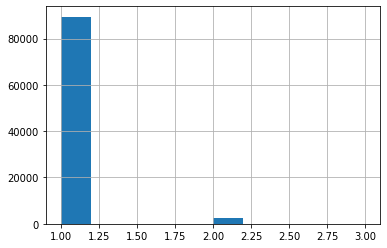

In [252]:
order_df.groupby('customer_unique_id')['payment_type'].nunique().hist()

In [253]:
order_df.groupby('customer_unique_id')['payment_type'].nunique().value_counts()

1    89426
2     2371
3       12
Name: payment_type, dtype: int64

In [254]:
order_df.groupby('payment_type')['customer_unique_id'].nunique()

payment_type
boleto         18407
credit_card    70834
debit_card      1439
voucher         3524
Name: customer_unique_id, dtype: int64

----
### [재주문 분석]
- 2회 이상 무언가를 구매한 유저 대상

In [255]:
user_df = order_df.groupby('customer_unique_id')['order_purchase_date'].nunique().reset_index()
user_df = user_df[user_df['order_purchase_date']>1]
user_df.head()

,customer_unique_id,order_purchase_date
103,004288347e5e88a27ded2bb23747066c,2
399,011575986092c30523ecb71ff10cb473,2
414,011b4adcd54683b480c4d841250a987f,2
423,012452d40dafae4df401bced74cdb490,2
432,012a218df8995d3ec3bb221828360c86,2


In [256]:
cuid_list = user_df['customer_unique_id'].tolist()
temp_df = order_df[order_df['customer_unique_id'].isin(cuid_list)]
temp_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,lat,lng,city,state,payment_type,payment_installments,payment_value,order_purchase_date,z_score_in_category,price_level
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83,2017-04-26,0.915267,2
40,0017afd5076e074a48f1f1a4c7bac9c5,fe59a1e006df3ac42bf0ceb876d70969,8085a9af46f619bc25966f151a362b0d,98758d88bf4b8eef1372ddee45d63178,1,809.10,44.29,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,...,-9.784323,-36.349941,campo alegre,AL,credit_card,10.0,853.39,2017-04-06,4.038650,2
56,0020a222f55eb79a372d0efee3cca688,e19ddcc85537b41f22116c8d5425ef46,0c45155afd8ff99622c40824057f9b34,87ae4c644c15d9c6b6f826dfec33b340,1,29.99,15.10,delivered,2017-08-15 02:45:18,2017-08-15 03:03:44,...,-22.518974,-44.136149,volta redonda,RJ,credit_card,4.0,45.09,2017-08-15,-0.643747,0
153,005d9a5423d47281ac463a968b3936fb,fb7a100ec8c7b34f60cec22b1a9a10e0,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,1,49.99,18.12,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18,-0.508681,1
154,005d9a5423d47281ac463a968b3936fb,4c3ae5db49258df0784827bdacf3b396,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,2,24.99,13.58,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18,-0.494177,0


In [820]:
temp_df.groupby('customer_unique_id')['product_id'].value_counts()

customer_unique_id                product_id                      
004288347e5e88a27ded2bb23747066c  6e1b14d3cbb5fb3a2c00351007127dfd    1
                                  a2bd2eae20998a24c22b110334928b02    1
011575986092c30523ecb71ff10cb473  098c663630a7a81f7d7f42a2ce0b02d7    1
                                  818430a64bb4e935b35f1f4da32612eb    1
011b4adcd54683b480c4d841250a987f  ed2067a9c1f79553088a3c67b99a9f97    2
                                                                     ..
ff8892f7c26aa0446da53d01b18df463  09690382191f134e947200ccfe32f7c0    1
                                  cfb763496d9fc48751a27db4fd02aa2d    1
ff922bdd6bafcdf99cb90d7f39cea5b3  b8762d562d810c2f8d7ad7e9c12957be    1
                                  e54cb69cc7bf5d21921991aae48501fb    1
                                  fd3a4121e687a6b84e7af92606d5d718    1
Name: product_id, Length: 4173, dtype: int64

In [261]:
def test(x):
    product_order_counts = x.value_counts()
    reorder_products = product_order_counts[product_order_counts>1]
    reorder_list = []
    for product_id, reorder_cnt in zip(reorder_products.index.tolist(), reorder_products.values.tolist()):
        reorder_list.append((product_id, reorder_cnt-1))
    return reorder_list

temp_df.groupby('customer_unique_id')['product_id'].apply(lambda x: test(x))

customer_unique_id
004288347e5e88a27ded2bb23747066c                                         []
011575986092c30523ecb71ff10cb473                                         []
011b4adcd54683b480c4d841250a987f    [(ed2067a9c1f79553088a3c67b99a9f97, 1)]
012452d40dafae4df401bced74cdb490    [(bb50f2e236e5eea0100680137654686c, 1)]
012a218df8995d3ec3bb221828360c86    [(e64fc38d9e0040126742405519bdea19, 1)]
                                                     ...                   
fe81bb32c243a86b2f86fbf053fe6140    [(e2bb00220a167d9e60b6776ac33717bc, 1)]
fed519569d16e690df6f89cb99d4e682                                         []
ff03923ad1eb9e32304deb7f9b2a45c9    [(6463e442310f2f4f321c83a32d8c662b, 1)]
ff8892f7c26aa0446da53d01b18df463                                         []
ff922bdd6bafcdf99cb90d7f39cea5b3                                         []
Name: product_id, Length: 1966, dtype: object

In [262]:
reorder_info_df = temp_df.groupby('customer_unique_id')['product_id'].apply(lambda x: test(x)).reset_index()
reorder_info_df.head()

,customer_unique_id,product_id
0,004288347e5e88a27ded2bb23747066c,[]
1,011575986092c30523ecb71ff10cb473,[]
2,011b4adcd54683b480c4d841250a987f,"[(ed2067a9c1f79553088a3c67b99a9f97, 1)]"
3,012452d40dafae4df401bced74cdb490,"[(bb50f2e236e5eea0100680137654686c, 1)]"
4,012a218df8995d3ec3bb221828360c86,"[(e64fc38d9e0040126742405519bdea19, 1)]"


In [263]:
reorder_info_df = reorder_info_df[reorder_info_df['product_id'].apply(lambda x: len(x)) > 0]
reorder_info_df.shape

(672, 2)

In [264]:
reorder_info_df.head()

,customer_unique_id,product_id
2,011b4adcd54683b480c4d841250a987f,"[(ed2067a9c1f79553088a3c67b99a9f97, 1)]"
3,012452d40dafae4df401bced74cdb490,"[(bb50f2e236e5eea0100680137654686c, 1)]"
4,012a218df8995d3ec3bb221828360c86,"[(e64fc38d9e0040126742405519bdea19, 1)]"
6,013f4353d26bb05dc6652f1269458d8d,"[(9e164b4afdecc7c67fb9b6f12c104e21, 1)]"
8,0178b244a5c281fb2ade54038dd4b161,"[(32dfa38395ccd47d7b320470b0514fee, 1)]"


----
#### *유저별 재주문 횟수*

In [265]:
reorder_info_df['reorder_total_count'] = reorder_info_df['product_id'].apply(lambda x: sum([tup[1] for tup in x]))

<AxesSubplot:>

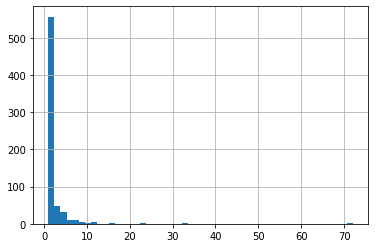

In [268]:
reorder_info_df['reorder_total_count'].hist(bins=50)

----
#### *재주문 많은 상품&카테고리*

In [273]:
reorder_info_df.head()

,customer_unique_id,product_id,reorder_total_count
2,011b4adcd54683b480c4d841250a987f,"[(ed2067a9c1f79553088a3c67b99a9f97, 1)]",1
3,012452d40dafae4df401bced74cdb490,"[(bb50f2e236e5eea0100680137654686c, 1)]",1
4,012a218df8995d3ec3bb221828360c86,"[(e64fc38d9e0040126742405519bdea19, 1)]",1
6,013f4353d26bb05dc6652f1269458d8d,"[(9e164b4afdecc7c67fb9b6f12c104e21, 1)]",1
8,0178b244a5c281fb2ade54038dd4b161,"[(32dfa38395ccd47d7b320470b0514fee, 1)]",1


In [270]:
product_reorder_dict = {}

for index, row in reorder_info_df.iterrows():
    for tup in row['product_id']:
        product_id, reorder_cnt = tup[0], tup[1]
        if product_id in product_reorder_dict:
            product_reorder_dict[product_id] += reorder_cnt
        else:
            product_reorder_dict[product_id] = reorder_cnt

In [271]:
# product_reorder_dict

In [272]:
sorted_dict = sorted(product_reorder_dict.items(), key = lambda item: item[1], reverse = True)
sorted_dict[:10]

[('ebf9bc6cd600eadd681384e3116fda85', 41),
 ('e7cc48a9daff5436f63d3aad9426f28b', 23),
 ('0449db5eede617c5fd413071d582f038', 23),
 ('5ddab10d5e0a23acb99acf56b62b3276', 20),
 ('89b190a046022486c635022524a974a8', 14),
 ('812f428f6757ab16c46cffc68f2e90c5', 12),
 ('04c4a4b9c924494fcf82e0fba966f955', 11),
 ('928e52a9ad53a294fdcc91bcf59d1751', 11),
 ('f3720bc68555b1bff49b9ffd41b017ac', 11),
 ('4eb99b5f0d7e411f246a5c9c0ae27a5e', 11)]

In [274]:
category_df = pd.read_csv(data_dir + "olist_products_dataset.csv")

In [275]:
product_category_dict = order_df[['product_id', 'product_category_name_english']].set_index('product_id').to_dict()

In [276]:
# product_category_dict['product_category_name_english']

In [277]:
for tup in sorted_dict[:10]:
    print(product_category_dict['product_category_name_english'][tup[0]])

bed_bath_table
telephony
garden_tools
housewares
furniture_decor
furniture_decor
watches_gifts
housewares
computers_accessories
furniture_decor


----
# 3. 유저향 시각화
### [거주 분포 시각화]

----
#### *시각화 할 데이터 전처리*

In [278]:
user_df = pd.read_csv(data_dir + "olist_customers_dataset.csv")
location_df = pd.read_csv(data_dir + "olist_geolocation_dataset.csv")

In [279]:
user_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [280]:
location_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [281]:
user_df['customer_zip_code_prefix'] = user_df['customer_zip_code_prefix'].astype(str)
location_df['geolocation_zip_code_prefix'] = location_df['geolocation_zip_code_prefix'].astype(str)
location_df.columns = ['customer_zip_code_prefix', 'lat', 'lng', 'city', 'state']
location_df = location_df.groupby('customer_zip_code_prefix').agg({'lat': 'mean', 'lng': 'mean', 'city': 'first', 'state': 'first'}).reset_index()
user_df = user_df.merge(location_df, how='left', on='customer_zip_code_prefix')

In [282]:
user_df = user_df.dropna()
user_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,lat,lng,city,state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,campinas,SP


----
#### *Bokeh 시각화*

In [283]:
# pip install bokeh
# https://docs.bokeh.org/en/latest/

from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *

In [284]:
# Web Mercator 데이터 포맷으로 변환
def wgs84_to_web_mercator(df, lng, lat):
    k = 6378137
    df["x"] = df[lng] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

order_df = wgs84_to_web_mercator(order_df, 'lng', 'lat')

In [285]:
city_df = user_df.groupby('city').agg({'customer_id' : ['count'], 'lat' : ['mean'], 'lng' : ['mean']})
city_df = city_df.reset_index()

In [286]:
city_df.columns = city_df.columns.to_flat_index()
city_df.columns = ['city', 'count', 'lat', 'lng']

In [287]:
city_df = wgs84_to_web_mercator(city_df, 'lng', 'lat')
city_df.head()

,city,count,lat,lng,x,y
0,abadia dos dourados,3,-18.474476,-47.407837,-5.277416e+06,-2.093161e+06
1,abadiania,1,-16.193742,-48.709521,-5.422319e+06,-1.827170e+06
2,abaete,12,-19.158206,-45.446300,-5.059059e+06,-2.173571e+06
3,abaetetuba,11,-1.723024,-48.881065,-5.441415e+06,-1.918351e+05
4,abaiara,2,-7.358247,-39.045817,-4.346560e+06,-8.213773e+05


In [ ]:
# 숙제 : city마다 unique한 customer_id를 count해서 BokehJS로 시각화 하세요
# 코드는 3회차 강의의 코드만 참고해서 짜보세요

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe0a44c6490>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe0a44c6bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe0a44c6100>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe0a44b8310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe0a44b86a0>],
 'means': []}

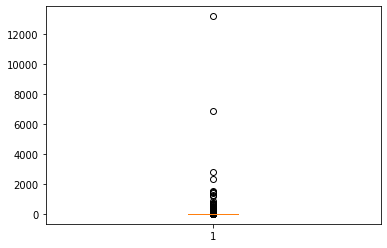

In [288]:
plt.boxplot(city_df['count'])

In [289]:
city_df['count'] = city_df['count'].apply(lambda x: np.log(x))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe07c01f190>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe07c01f8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe000854df0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe07c01ffd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe07c00a3a0>],
 'means': []}

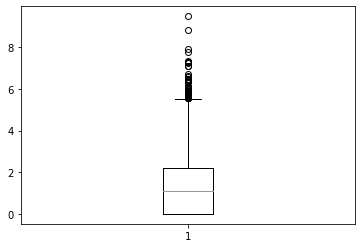

In [290]:
plt.boxplot(city_df['count'])

In [291]:
# 맵의 확대 정도 지정
zoom_scale = 3000
x = order_df['x']
y = order_df['y']

# 지도에서 표시할 x,y의 범위 지정
x_min = int(x.mean() - (zoom_scale * 350))
x_max = int(x.mean() + (zoom_scale * 350))
y_min = int(y.mean() - (zoom_scale * 350))
y_max = int(y.mean() + (zoom_scale * 350))

# 사용할 지도의 스타일 정의 : OSM, ESRI, google Type...
tile_provider = get_provider(OSM)

# Bokh 플롯 객체를 설정하고 지도 타일을 언더레이로 추가.
plot = figure(
    title='E-commerce Order Map',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=500
    )

# 지도 그리드 표시
plot.grid.visible = True

map = plot.add_tile(tile_provider)
map.level = 'underlay'

# x와 y축은 숨김.
plot.xaxis.visible = False
plot.yaxis.visible = False

# notebook에 BokehJS 객체 로드
output_notebook()

Loading BokehJS ...

In [292]:
def bubble_map(plot, df, count_col, leg_label, lon, lat, scale):
    # color palete 지정
    mapper = LinearColorMapper(
        palette='Greys256',
        low=df[count_col].max(),
        high=df[count_col].min()
    )

    # 지도에 circle 포인트 그리기
    c = plot.circle(x='x',
                    y='y',
                    color=transform(count_col, mapper),
                    size=7,
                    alpha=0.4,
                    source=df,
                    legend_label=leg_label)
    
    # mouse hover에 표기할 정보
    tip_label='@'+count_col
    lat_label='@'+lat
    lon_label='@'+lon
    circle_hover = HoverTool(tooltips=[(count_col, tip_label), ('Lat:', lat_label), ('Lon:', lon_label)], 
                             mode='mouse', 
                             point_policy='follow_mouse', 
                             renderers=[c])
    circle_hover.renderers.append(c)
    
    # mouse hover와 legend 정보 부착
    plot.tools.append(circle_hover)
    plot.legend.location = "top_right"
    plot.legend.click_policy="hide"
    
    # color bar 정보 부착
    color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 12,
                     location = (0,0),
                     title = 'order count')
    plot.add_layout(color_bar, 'right')

In [293]:
# Create bubble map
bubble_map(plot=plot,
           df=city_df,
           count_col='count', 
           leg_label='Order Count Map',
           lon='lng',
           lat='lat',
           scale=zoom_scale)

In [294]:
show(plot)

----
# 4. 프로파일 기반 군집분석
### [유저 프로파일의 벡터 표현]

----
#### *features from user profile EDA*
- order count (non-unique order id)
- prefer price level
- payment value
- order category (multi-hot with normalized)

In [295]:
# 유저별 주문 갯수
order_df['order_stuff_count'] = order_df.groupby('customer_unique_id')['order_id'].transform(lambda x: x.count())
order_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,state,payment_type,payment_installments,payment_value,order_purchase_date,z_score_in_category,price_level,x,y,order_stuff_count
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,RJ,credit_card,2.0,72.19,2017-09-13,-0.567002,1,-4.598567e+06,-2.483067e+06,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,SP,credit_card,3.0,259.83,2017-04-26,0.915267,2,-5.666543e+06,-2.299174e+06,2
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,MG,credit_card,5.0,216.87,2018-01-14,1.257364,2,-4.964106e+06,-2.257673e+06,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,...,SP,credit_card,2.0,25.78,2018-08-08,-1.017445,0,-5.188786e+06,-2.642897e+06,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,...,SP,credit_card,3.0,218.04,2017-02-04,0.452103,2,-5.212826e+06,-2.661481e+06,1


----
#### *numerical feature engineering*

In [296]:
# 0~1 사이의 값으로 normalize
order_df['price_level'] = order_df['price_level'] / 2

In [297]:
user_feature_df = order_df.groupby('customer_unique_id').agg({'order_id': 'count', 'price_level': 'mean', 'payment_value': 'sum', 'product_category_name_english': list})

In [298]:
user_feature_df.sample(5).head()

,order_id,price_level,payment_value,product_category_name_english
customer_unique_id,,,,
276175229d0061ba2c4e4c6bc1f93d10,1,1.0,274.97,[baby]
15ab167f3095a52c27d26e1e9088610f,1,0.5,82.02,[cool_stuff]
7ed17e9562359869ad07944a189eda2f,1,0.5,154.81,[baby]
246cc3392571eab3ff30b600972b83b1,1,0.5,65.71,[auto]
91dd3e913cf5d632ce605a3689a5126a,2,1.0,2268.88,"[agro_industry_and_commerce, agro_industry_and..."


<AxesSubplot:>

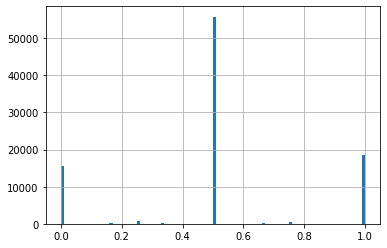

In [299]:
user_feature_df['price_level'].hist(bins=100)

<AxesSubplot:>

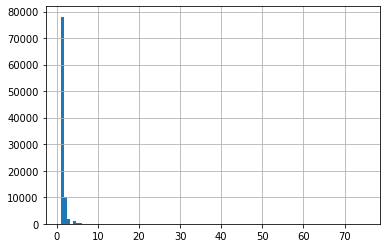

In [300]:
user_feature_df['order_id'].hist(bins=100)

In [301]:
user_feature_df['order_id'].value_counts()

1     78041
2     10234
3      1877
4       873
5       293
6       267
7        71
8        38
12       22
9        19
10       18
11       18
14        8
15        5
13        5
20        4
24        4
21        3
16        2
18        1
19        1
22        1
26        1
38        1
75        1
35        1
Name: order_id, dtype: int64

In [302]:
# 구매 활동성을 3-level로 구분
user_feature_df['order_id'] = user_feature_df['order_id'].apply(lambda x: 3 if x >= 3 else x)
user_feature_df['price_level'] = user_feature_df['price_level'] / 3

In [303]:
user_feature_df['order_id'].value_counts()

1    78041
2    10234
3     3534
Name: order_id, dtype: int64

In [304]:
# log normalization 후, 0~1 사이의 값으로 다시 normalize
user_feature_df['payment_value'] = np.log(user_feature_df['payment_value'])
user_feature_df['payment_value'] = (user_feature_df['payment_value'] - user_feature_df['payment_value'].min()) / (user_feature_df['payment_value'].max() - user_feature_df['payment_value'].min())

<AxesSubplot:>

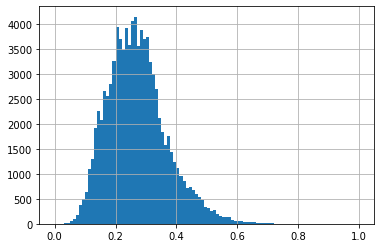

In [305]:
user_feature_df['payment_value'].hist(bins=100)

In [306]:
user_feature_df.head()

,order_id,price_level,payment_value,product_category_name_english
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table]
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty]
0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery]
0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony]
0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony]


In [307]:
# user_feature_df.columns = user_feature_df.columns.to_flat_index()
user_feature_df.columns = ['order_count', 'prefer_price_level', 'total_payment', 'product_category_name_english']

In [316]:
user_feature_df.head()

,order_count,prefer_price_level,total_payment,product_category_name_english,category_counter_obj
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table],{'bed_bath_table': 1.0}
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty],{'health_beauty': 1.0}
0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery],{'stationery': 1.0}
0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony],{'telephony': 1.0}
0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony],{'telephony': 1.0}


----
#### *categorical feature engineering*

In [309]:
from collections import Counter

data = [(1,1,2), (3,3,2,5)]
pd.DataFrame([Counter(x) for x in data]).fillna(0)

,1,2,3,5
0,2.0,1,0.0,0.0
1,0.0,1,2.0,1.0


In [310]:
Counter((1,1,2))

Counter({1: 2, 2: 1})

In [311]:
counts = Counter(['watches_gifts', 'watches_gifts', 'watches'])
for item, count in counts.items():
    print(item, count)
    counts[item] /= sum(counts.values())

watches_gifts 2
watches 1


In [317]:
def get_counter_objs(x):
    counts = Counter(x)
    for item, count in counts.items():
        counts[item] /= sum(counts.values())
    return counts

user_feature_df['category_counter_obj'] = user_feature_df['product_category_name_english'].apply(lambda x: get_counter_objs(x))

In [325]:
user_feature_df.head()

,order_count,prefer_price_level,total_payment,product_category_name_english,category_counter_obj
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table],{'bed_bath_table': 1.0}
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty],{'health_beauty': 1.0}
0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery],{'stationery': 1.0}
0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony],{'telephony': 1.0}
0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony],{'telephony': 1.0}


In [326]:
user_feature_df = user_feature_df.reset_index(inplace=False)

In [327]:
user_feature_df.head()

,customer_unique_id,order_count,prefer_price_level,total_payment,product_category_name_english,category_counter_obj
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table],{'bed_bath_table': 1.0}
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty],{'health_beauty': 1.0}
2,0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery],{'stationery': 1.0}
3,0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony],{'telephony': 1.0}
4,0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony],{'telephony': 1.0}


In [328]:
data = user_feature_df['category_counter_obj'].tolist()
category_counter_df = pd.DataFrame(data).fillna(0)

In [329]:
category_counter_df.head()

,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,luggage_accessories,computers_accessories,fashion_underwear_beach,...,cds_dvds_musicals,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [330]:
user_feature_df.shape

(91809, 6)

In [331]:
category_counter_df.shape

(91809, 71)

In [332]:
kmeans_df = pd.concat([user_feature_df[['order_count', 'prefer_price_level', 'total_payment']], category_counter_df], axis=1)

In [333]:
kmeans_df.shape

(91809, 74)

In [334]:
kmeans_df.head()

,order_count,prefer_price_level,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,...,cds_dvds_musicals,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine
0,1,0.333333,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.000000,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.166667,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.166667,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.333333,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


----
### [다양한 관점으로 K-means 군집 분석 수행]

k: 1 | cost: 1841.3826921466323
k: 2 | cost: 879.682267111217
k: 3 | cost: 484.28763213496666
k: 4 | cost: 328.0544252854886
k: 5 | cost: 242.89847909727013
k: 6 | cost: 180.23078301225647
k: 7 | cost: 141.26287017133885
k: 8 | cost: 119.68489001832192
k: 9 | cost: 103.112540209381


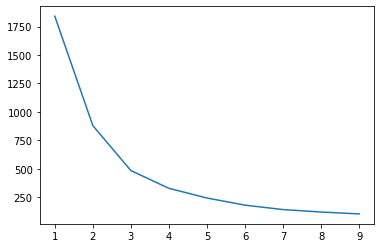

In [335]:
from sklearn.cluster import KMeans

# K-means train & Elbow method
X = kmeans_df[['prefer_price_level', 'total_payment']]

k_list = []
cost_list = []
for k in range (1, 10):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
    
plt.plot(k_list, cost_list)

In [336]:
# selected by elbow method
kmeans = KMeans(n_clusters=4).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
kmeans_df['cluster_num'] = cluster.values
kmeans_df.head()

,order_count,prefer_price_level,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,...,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine,cluster_num
0,1,0.333333,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,0.000000,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1,0.166667,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,0.166667,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1,0.333333,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [337]:
print(kmeans_df['cluster_num'].value_counts())

0    47366
1    19194
2    14625
3    10624
Name: cluster_num, dtype: int64


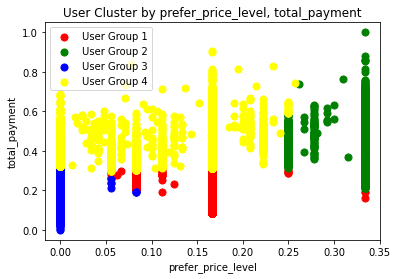

In [338]:
# Visualization
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 0]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 0]['total_payment'], 
            s = 50, c = 'red', label = 'User Group 1')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 1]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 1]['total_payment'], 
            s = 50, c = 'green', label = 'User Group 2')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 2]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 2]['total_payment'], 
            s = 50, c = 'blue', label = 'User Group 3')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 3]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 3]['total_payment'], 
            s = 50, c = 'yellow', label = 'User Group 4')
plt.title('User Cluster by prefer_price_level, total_payment')
plt.xlabel('prefer_price_level')
plt.ylabel('total_payment')
plt.legend()
plt.show()

In [339]:
# selected by elbow method
kmeans = KMeans(n_clusters=6).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
kmeans_df['cluster_num'] = cluster.values
kmeans_df.head()

,order_count,prefer_price_level,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,...,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine,cluster_num
0,1,0.333333,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,0.000000,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1,0.166667,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,1,0.166667,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,1,0.333333,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [340]:
print(kmeans_df['cluster_num'].value_counts())

0    27190
5    24352
2    14705
3    14585
4     6172
1     4805
Name: cluster_num, dtype: int64


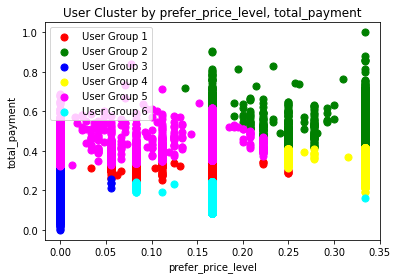

In [341]:
# Visualization
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 0]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 0]['total_payment'], 
            s = 50, c = 'red', label = 'User Group 1')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 1]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 1]['total_payment'], 
            s = 50, c = 'green', label = 'User Group 2')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 2]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 2]['total_payment'], 
            s = 50, c = 'blue', label = 'User Group 3')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 3]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 3]['total_payment'], 
            s = 50, c = 'yellow', label = 'User Group 4')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 4]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 4]['total_payment'], 
            s = 50, c = 'magenta', label = 'User Group 5')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 5]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 5]['total_payment'], 
            s = 50, c = 'cyan', label = 'User Group 6')
# plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 6]['prefer_price_level'], 
#             kmeans_df[kmeans_df['cluster_num'] == 6]['total_payment'], 
#             s = 50, c = 'black', label = 'User Group 7')
# plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 7]['prefer_price_level'], 
#             kmeans_df[kmeans_df['cluster_num'] == 7]['total_payment'], 
#             s = 50, c = 'orange', label = 'User Group 8')
plt.title('User Cluster by prefer_price_level, total_payment')
plt.xlabel('prefer_price_level')
plt.ylabel('total_payment')
plt.legend()
plt.show()

----
### [t-sne 차원 축소 시각화]

In [1009]:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=300)
transformed = model.fit_transform(kmeans_df[])

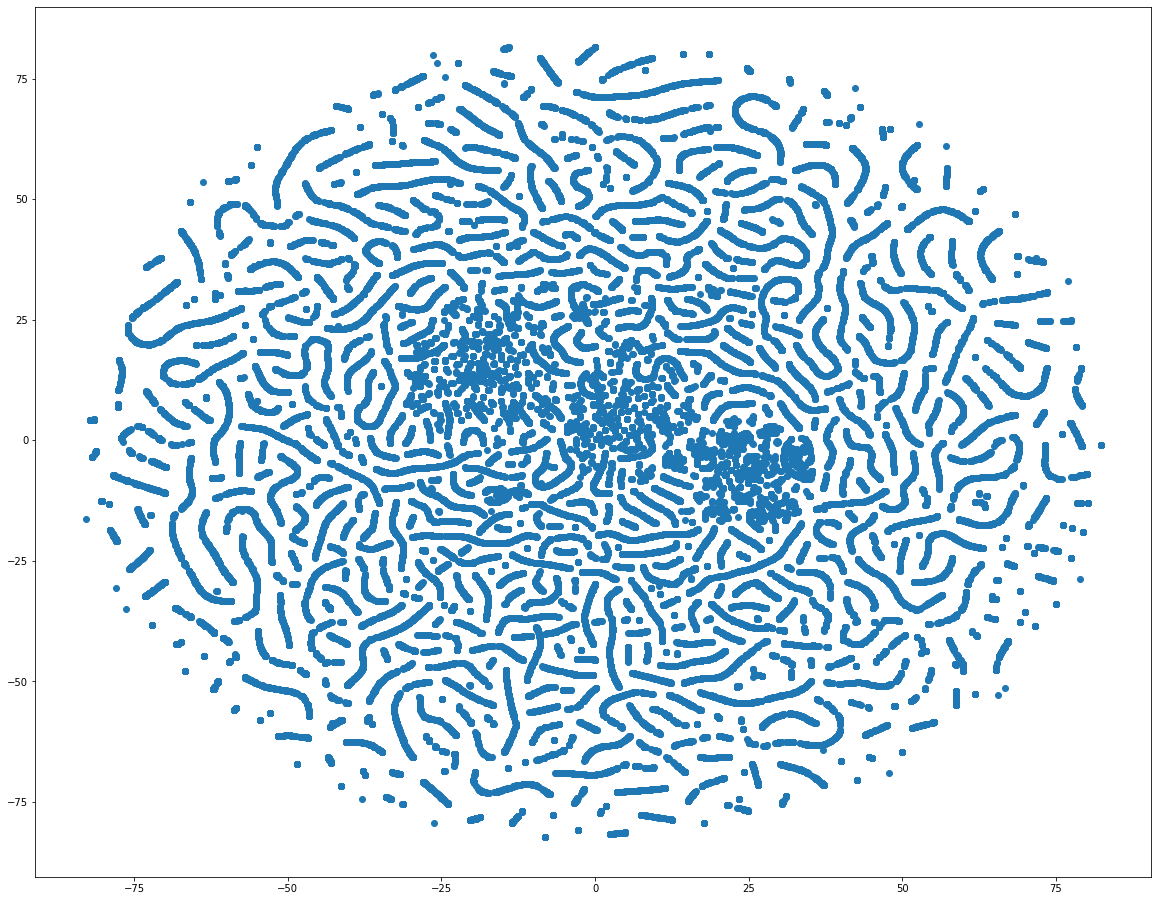

In [1010]:
plt.rcParams['figure.figsize'] = [20, 16]
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

In [1014]:
kmeans_df[kmeans_df.columns[~kmeans_df.columns.isin(['order_count','prefer_price_level'])]]

,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,luggage_accessories,computers_accessories,...,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine,cluster_num
0,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91804,0.649430,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
91805,0.233050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
91806,0.263549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
91807,0.282061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1015]:
model = TSNE(learning_rate=300)
transformed = model.fit_transform(kmeans_df[kmeans_df.columns[~kmeans_df.columns.isin(['order_count','prefer_price_level'])]])

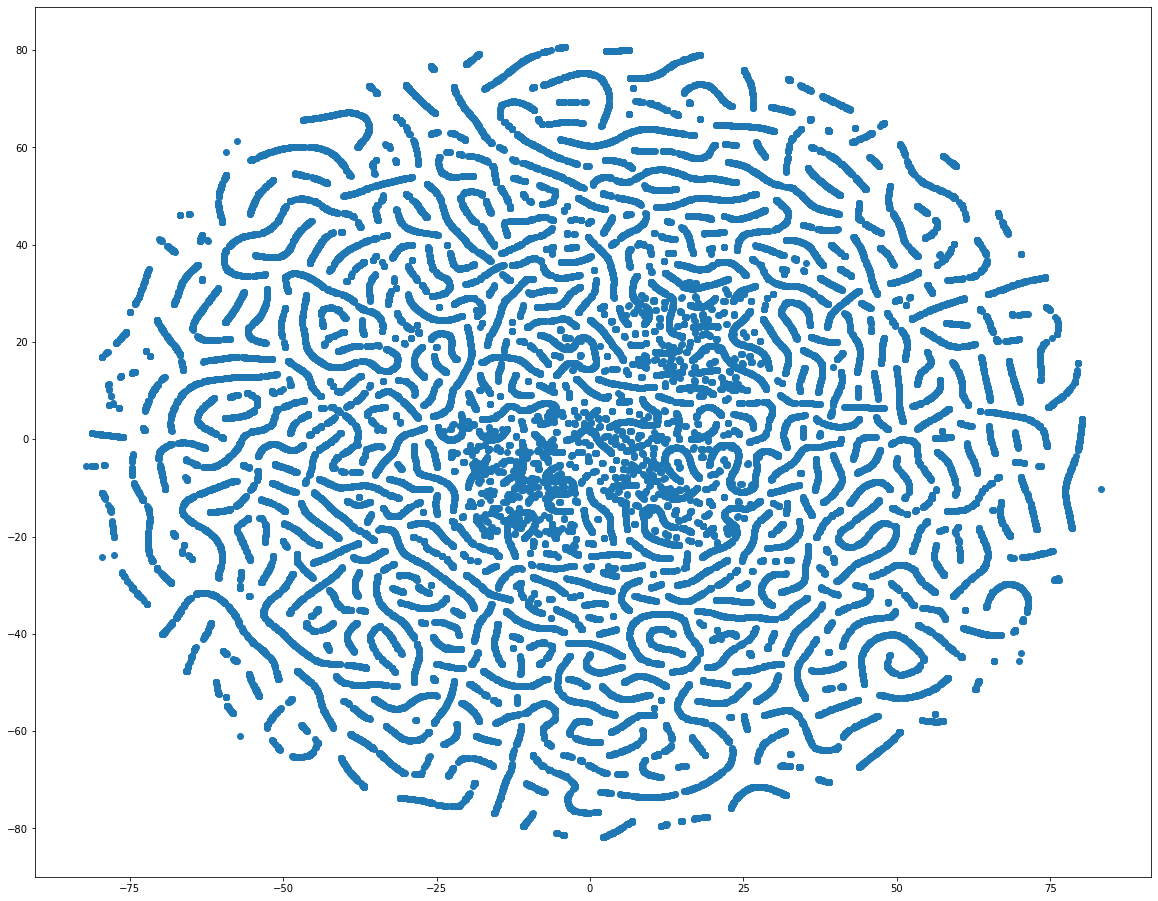

In [1016]:
plt.rcParams['figure.figsize'] = [20, 16]
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

----
# 5. 심화 예제
### [유저 행동 기반 장바구니 분석]

----
#### *Association Rule*

In [1020]:
from apyori import apriori

# 장바구니 형태의 데이터(트랜잭션 데이터)를 생성합니다.
transactions = [
    ['손흥민', '시소코'],
    ['손흥민', '케인'],
    ['손흥민', '케인', '포체티노']
]

# 연관 분석을 수행합니다.
results = list(apriori(transactions))
for result in results:
    print(result)

RelationRecord(items=frozenset({'손흥민'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)])
RelationRecord(items=frozenset({'시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'시소코'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0)])
RelationRecord(items=frozenset({'포체티노'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'포체티노'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'손흥민', '시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민', '시소코'}), confidence=0.3333333333333333, lift=1.0), Or

In [1021]:
# 지지도 0.5, 신뢰도 0.6, 향상도 1.0 이상이면서 (손흥민, 케인) 처럼 규칙의 크기가 2 이하인 규칙을 추출합니다.
list(apriori(transactions,
             min_support=0.5,
             min_confidence=0.6,
             min_lift=1.0,
             max_length=2))

[RelationRecord(items=frozenset({'손흥민'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)]),
 RelationRecord(items=frozenset({'케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0)]),
 RelationRecord(items=frozenset({'손흥민', '케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민', '케인'}), confidence=0.6666666666666666, lift=1.0), OrderedStatistic(items_base=frozenset({'손흥민'}), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0), OrderedStatistic(items_base=frozenset({'케인'}), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)])]

In [1067]:
user_transactions = order_df.groupby('customer_unique_id')['product_category_name_english'].unique().reset_index()

In [1068]:
user_transactions.head()

,customer_unique_id,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,[bed_bath_table]
1,0000b849f77a49e4a4ce2b2a4ca5be3f,[health_beauty]
2,0000f46a3911fa3c0805444483337064,[stationery]
3,0000f6ccb0745a6a4b88665a16c9f078,[telephony]
4,0004aac84e0df4da2b147fca70cf8255,[telephony]


In [1069]:
user_transactions[user_transactions['product_category_name_english'].map(len) > 1]

,customer_unique_id,product_category_name_english
22,000fbf0473c10fc1ab6f8d2d286ce20c,"[musical_instruments, toys]"
35,001926cef41060fae572e2e7b30bd2a4,"[electronics, computers_accessories]"
36,001928b561575b2821c92254a2327d06,"[furniture_living_room, bed_bath_table]"
103,004288347e5e88a27ded2bb23747066c,"[luggage_accessories, cool_stuff]"
224,0097fca0db567f5ca79509b7b4fc1c2d,"[flowers, furniture_decor]"
...,...,...
91380,fed2005ccab4fcf1a40ebdaff032a148,"[computers_accessories, telephony]"
91384,fed519569d16e690df6f89cb99d4e682,"[toys, bed_bath_table]"
91583,ff5f29fbfd0a13f7e7ed9f7b92a32194,"[bed_bath_table, home_confort]"
91644,ff8892f7c26aa0446da53d01b18df463,"[bed_bath_table, watches_gifts]"


In [1070]:
user_transactions = user_transactions[user_transactions['product_category_name_english'].map(len) > 1]

In [1071]:
user_transactions['product_category_name_english'].tolist()[:10]

[array(['musical_instruments', 'toys'], dtype=object),
 array(['electronics', 'computers_accessories'], dtype=object),
 array(['furniture_living_room', 'bed_bath_table'], dtype=object),
 array(['luggage_accessories', 'cool_stuff'], dtype=object),
 array(['flowers', 'furniture_decor'], dtype=object),
 array(['furniture_decor', 'baby'], dtype=object),
 array(['home_appliances', 'bed_bath_table'], dtype=object),
 array(['bed_bath_table', 'housewares'], dtype=object),
 array(['garden_tools', 'auto'], dtype=object),
 array(['toys', 'musical_instruments'], dtype=object)]

In [1072]:
user_transactions['product_category_name_english'] = user_transactions['product_category_name_english'].apply(lambda x: x.tolist())

In [1073]:
user_transactions['product_category_name_english'].tolist()[:10]

[['musical_instruments', 'toys'],
 ['electronics', 'computers_accessories'],
 ['furniture_living_room', 'bed_bath_table'],
 ['luggage_accessories', 'cool_stuff'],
 ['flowers', 'furniture_decor'],
 ['furniture_decor', 'baby'],
 ['home_appliances', 'bed_bath_table'],
 ['bed_bath_table', 'housewares'],
 ['garden_tools', 'auto'],
 ['toys', 'musical_instruments']]

In [1074]:
transactions = user_transactions['product_category_name_english'].tolist()

In [1075]:
results = list(apriori(transactions,
                       min_support=0.001,
                       min_confidence=0.01,
                       min_lift=1.0,
                       max_length=2))

In [1076]:
results[:3]

[RelationRecord(items=frozenset({'auto'}), support=0.056638811513463325, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'auto'}), confidence=0.056638811513463325, lift=1.0)]),
 RelationRecord(items=frozenset({'baby'}), support=0.07845868152274837, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'baby'}), confidence=0.07845868152274837, lift=1.0)]),
 RelationRecord(items=frozenset({'bed_bath_table'}), support=0.24419684308263695, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'bed_bath_table'}), confidence=0.24419684308263695, lift=1.0)])]

In [1077]:
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        print(items[0], "||", items[1], result.support)

air_conditioning || sports_leisure 0.001392757660167131
furniture_decor || art 0.002785515320334262
audio || watches_gifts 0.003714020427112349
auto || consoles_games 0.001392757660167131
construction_tools_construction || auto 0.001392757660167131
auto || electronics 0.002321262766945218
auto || pet_shop 0.0018570102135561746
auto || telephony 0.004178272980501393
baby || bed_bath_table 0.017177344475394613
baby || cool_stuff 0.014391829155060354
fashion_shoes || baby 0.001392757660167131
toys || baby 0.012534818941504178
bed_bath_table || cool_stuff 0.010677808727948004
fashion_underwear_beach || bed_bath_table 0.001392757660167131
furniture_decor || bed_bath_table 0.07056638811513463
health_beauty || bed_bath_table 0.012999071494893221
home_confort || bed_bath_table 0.025069637883008356
housewares || bed_bath_table 0.02924791086350975
kitchen_dining_laundry_garden_furniture || bed_bath_table 0.002785515320334262
computers_accessories || electronics 0.00510677808727948
computers_acce